<a href="https://colab.research.google.com/github/AbdulHamidDabboussi/twitter-airline-sentiment/blob/master/Airlines_tweet_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data from Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive/My\ Drive/Bilkent

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
 models   Tweets.csv  'Year 3'


# Import Libraries 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from fastai.text import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
%matplotlib inline 

# Data Analysis

In [3]:
root = '/gdrive/My Drive/Bilkent/'
path = os.path.join(root, 'Tweets.csv')
df = pd.read_csv(path)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We visualize the distribution of the airlines' sentiment among all tweets and see that the data is skewed towards negative tweets.

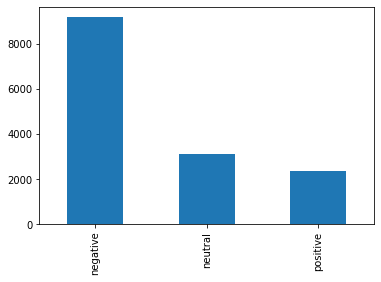

In [ ]:
df['airline_sentiment'].value_counts().plot(kind='bar')

We also look at the number of tweets and sentiment per airline and see that the above property is constistent among all six companies.

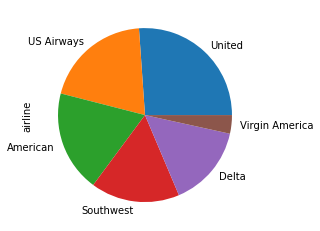

In [ ]:
df['airline'].value_counts().plot(kind='pie')

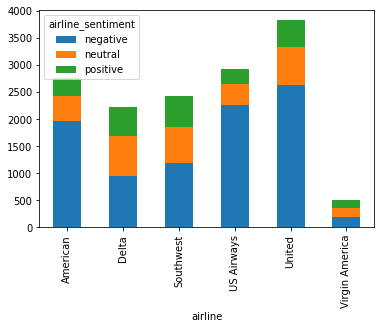

In [ ]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

We can also see that the main reason for negative response is bad customer service.

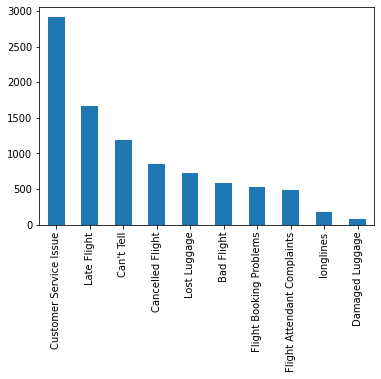

In [ ]:
df['negativereason'].value_counts().plot(kind='bar')

By removing *stopwords* and focusing on tweets with a negative sentiment, we can see the most recurring words characteristic of these tweets.

In [ ]:
tweets=df[df['airline_sentiment']=='negative']
words = ' '.join(tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=6000, height=4000).generate(cleaned_word)

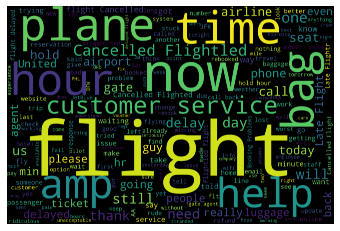

In [ ]:
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Getting data ready for modeling

In [4]:
test_percentage = 0.8
cutoff = int(test_percentage * df.shape[0])
df[['airline_sentiment', 'text']][cutoff:].to_csv('test.csv', index=False, encoding='utf-8')
df[['airline_sentiment', 'text']][:cutoff].to_csv('train.csv', index=False, encoding='utf-8')
df[['text']][:cutoff].to_csv('train_text.csv', index=False, encoding='utf-8')

In [5]:
# Language model data
data_lm = (TextList.from_csv('.', 'train_text.csv')
            .split_by_rand_pct(0.1, seed = 42)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=64))

In [6]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"$ 30 a flight for seats that did n't have this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a xxunk opportunity for xxmaj xxunk xxmaj without xxmaj xxunk xxunk , there . https : / /"
1,xxunk xxmaj cancelled xxmaj flightlation notice we were left w no options to fly out of xxup ps . xxmaj driving to xxup la for a red eye xxmaj mon w kids xxbos @virginamerica trying to book a flight & & your site is down 😁 xxbos @virginamerica xxmaj you have any flights flying into xxmaj boston tomorrow ? i need to be home and you xxmaj cancelled xxmaj flightled
2,site does n't work on iphone or xxunk have a computer # help xxbos @virginamerica thank you xxbos @virginamerica xxmaj can i get some help with a support ticket ? xxmaj it 's been 15 days xxrep 4 . xxmaj incident : xxunk - xxunk xxmaj thank you ! xxbos @virginamerica good to be home # texas # xxunk http : / / t.co / xxunk xxbos .@virginamerica xxmaj if
3,"right . xxbos @united another fail for the xxmaj united ticket agents in xxup okc . xxup less than helpful and could care less about our problems . xxmaj american here we come . xxbos @united xxunk , which also had 1 working xxup xxunk in coach . xxmaj good thing this bird landed ahead of schedule . i have to use the xxup xxunk stat . xxbos @united the"
4,people at the counter have been very helpful . xxmaj as you can see nobody is there . xxmaj flight to xxmaj austin xxunk and still sitting here . xxbos @united unfortunately still on the xxmaj tarmac at @fly2ohare and definitely missing my ride from xxunk # xxunk xxbos “ @united : xxunk xxmaj we regret to hear this . xxmaj please let us know if you need assistance .


In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.2)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


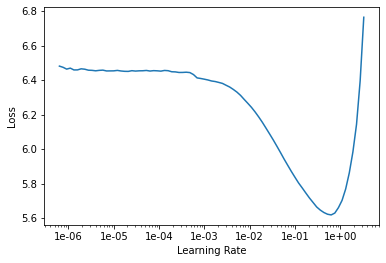

In [11]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1, 1e-2)    

epoch,train_loss,valid_loss,accuracy,time
0,4.726240,4.118822,0.235874,25:04


In [13]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.810817,3.752506,0.287277,34:48


In [17]:
learn.save_encoder('encoder')

In [19]:
learn.predict('My flight was bad because', n_words=20)

'My flight was bad because i found out in front six of us left the gate in the two hours before we were put ('

Now for the classifier, we make use of the encoder generated above.

In [20]:
#Classifier model data
data_clas = (TextList.from_csv('.', 'train.csv', cols = 'text')               
             .split_by_rand_pct(0.1, seed = 42)
             .label_from_df(cols=0)
             .databunch(bs=32))

In [21]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag xxunk for xxup jac - xxup lax ?,neutral
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj xxunk xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
"xxbos xxup @usairways xxup are xxup you xxup kidding xxup me ? ? xxmaj bad customer service , folks . xxmaj flew from xxup psp to xxup phx flight xxunk on 2 / 19 . ( cont ) http : / / t.co / xxunk",negative
"xxbos @usairways yes , i am as well . * * xxup five * * xxup hours xxup on xxup hold , xxup folks . xxmaj can you xxup please tell me if this is typical ? ! xxmaj trying to be understanding here .",negative
xxbos @united : xxmaj unhappy with xxmaj united 's service ? \n \n xxmaj read xxmaj xxunk xxmaj xxunk 's open letter to xxup ual 's xxup ceo . \n \n xxmaj leave a comment or xxup rt . \n \n http : / / t.co / xxunk,negative


In [24]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('encoder')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (10541 items)
x: TextList
xxbos @virginamerica plus you 've added commercials to the experience ... xxunk .,xxbos @virginamerica i did n't today ... xxmaj must mean i need to take another trip !,xxbos @virginamerica it 's really aggressive to xxunk xxunk " entertainment " in your guests ' faces & & they have little recourse,xxbos @virginamerica and it 's a really big bad thing about it,xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . 
  it 's really the only bad thing about flying xxup va
y: CategoryList
positive,neutral,negative,negative,negative
Path: .;

Valid: LabelList (1171 items)
x: TextList
xxbos @usairways great operation you guys are running . xxmaj more mechanical issues , and now xxunk piece of plane together xxup lol http : / / t.co / xxunk,xxbos @jetblue xxmaj thanks for the xxunk customer service ! # xxunk # xxunk,xxbos @southwestair the woman working the counter in phil

In [25]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.758439,0.633300,0.771136,16:38


In [27]:
learn.unfreeze()
learn.fit_one_cycle(1, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.612918,0.475596,0.820666,38:45


Now that we have trianed the model and are satisfied by the validation accuracy, we can test on the test set.

In [ ]:
test_set = pd.read_csv('test.csv', encoding='utf-8')
test_set['pred_sentiment'] = test_set['text'].apply(lambda row: str(learn.predict(row)[0]))

In [29]:
print("Accuracy: ", metrics.accuracy_score(test_set['airline_sentiment'], test_set['pred_sentiment']))

Accuracy:  0.8401639344262295
